# 1. Tennis Surface Check

Use a linear regression and statsmodels to find which surface type predicts the most points for Federer in the `tennis.csv` dataset.

1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value. 

2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [739]:
# making the OHE for surfaces:
df = pd.read_csv('data/tennis.csv')
x = pd.get_dummies(df['surface'], drop_first=True)
x.head()

,Indoor: Clay,Indoor: Hard,Outdoor: Clay,Outdoor: Grass,Outdoor: Hard
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


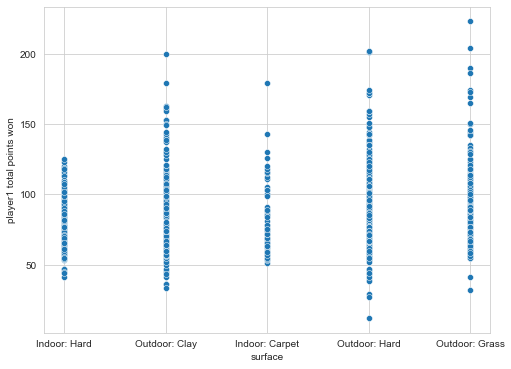

In [742]:
plt.subplots(figsize=(8,6))
sns.scatterplot(x='surface', y='player1 total points won', data=df)

In [738]:
# le model: 
est = sm.OLS(
    df['player1 total points won'], 
    sm.add_constant(x), missing='drop').fit(cov_type='HC2')
est.summary() 

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.046
Model:                                  OLS   Adj. R-squared:                  0.042
Method:                       Least Squares   F-statistic:                     16.58
Date:                      Tue, 19 Jan 2021   Prob (F-statistic):           3.59e-13
Time:                              19:49:05   Log-Likelihood:                -4849.5
No. Observations:                      1027   AIC:                             9709.
Df Residuals:                          1022   BIC:                             9734.
Df Model:                                 4                                         
Covariance Type:                        HC2                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             83.2281      3.411     24.403      0.000      76.543      89.913
Indoor: Clay   -4.198e-14   5.74e-15     -7.313      0.000   -5.32e-14   -3.07e-14
Indoor: Hard      -6.1456      3.629     -1.693      0.090     -13.259       0.968
Outdoor: Clay      4.8599      3.990      1.218      0.223      -2.961      12.680
Outdoor: Grass    14.9386      4.492      3.326      0.001       6.135      23.742
Outdoor: Hard      4.4635      3.657      1.221      0.222      -2.703      11.630
==============================================================================
Omnibus:                      147.179   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.816
Skew:                           0.932   Prob(JB):                     1.88e-53
Kurtosis:                       4.484   Cond. No.                     3.90e+16
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 8.68e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [740]:
# 1. Give a one-paragraph interpretation of the coefficients, and the meaning of the p-value.

## For this linear regression using OHE of 'surfaces', we can interpret the coefficients and p-value as follows: the constant is 83.2281 and represents the number of points on that surface when all other features (surfaces) are at 0. Since we dropped the first feature, this means the 83 points is for the dropped feature (Indoor: Carpet). The next feature's (Indoor: Clay) coeff is basically 0 (-4.198e-14), meaning that for this feature, the total points are 83 + 0. For Indoor Hard, Federers points are 77.08 (83.2281 - 6.1456). For Outdoor Clay: 83 + 4.8599. For Outdoor Grass: 83 + 14.9386. And for Outdoor Hard: 83 + 4.4635. So most points on Outdoor Grass and least on Indoor Hard... however, when we take a look at the pvalues, we see that only Outdoor Grass, Indoor Clay and constant (Indoor Carpet) are significant. 
## The p-values represent whether the line from these coefficients is statistically significant from 0. For the features that have a high p value (p > .05), we cannot say the their coefficients is different from zero, i.e. there is no difference between them and the base case (Indoor Carpet). The only ones that are statistically significant are the constant, Indoor Clay, and Outdoor Grass (p < .05). 


# 2. Answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

## Yes, the regression should include a constant term because the formula used for calculating R-squared without the constant is incorrect. We could not include the constant and not drop the 1st surface (would give us the same 83.2281 for Indoor Carpet), but then our R2 would be wrong. We need to drop the 1st OHE feature and include the constant so we know what we are comparing the other features to (i.e., the dropped one). Also, with a constant, a lot of the coefficients become insignificant, indicating that our choice of features for the model is probably not the best for predicting Federer's points. 
# Also, the AIC and BIC are lower (i.e., better) with a constant. 


# 3. Do a t-test to find that the largest coefficient is statistically significantly different from the second largest (hint: you can run a t-test only with mean values and standard deviations): 

from scipy.stats import ttest_ind_from_stats

# 1 = Outdoor: Clay
# 2 = Outdoor: Grass
# Outdoor: Clay	4.8599	4.059	1.197	0.232	-3.106	12.826
# Outdoor: Grass	14.9386	4.321	3.457	0.001	6.460	23.417

ttest_ind_from_stats(mean1=4.8599, std1=4.059, nobs1=1027,
                     mean2=14.9386, std2=4.321, nobs2=1027)

# The largest coefficient is statistically significantly diffrent from the second largest coefficient (t = -54.48, p < .05)

Ttest_indResult(statistic=-54.481438083892506, pvalue=0.0)

In [156]:
# Just to double check that the surface type of 'outdoor' correlates with higher points 
df['in_out'] = df['surface'].str.split(':', expand=True)[0]
xx = pd.get_dummies(df['in_out'], drop_first=True)
xx

est = sm.OLS(
    df['player1 total points won'], 
    sm.add_constant(xx), missing='drop').fit()
est.summary() 

# yes, 'outdoor' has higher number of total points like in previous model. Cool. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.029
Model:                                  OLS   Adj. R-squared:                  0.028
Method:                       Least Squares   F-statistic:                     31.02
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):           3.26e-08
Time:                              12:01:32   Log-Likelihood:                -4858.5
No. Observations:                      1027   AIC:                             9721.
Df Residuals:                          1025   BIC:                             9731.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.4781      1.733     45.277      0.000      75.077      81.879
Outdoor       11.1057      1.994      5.569      0.000       7.193      15.019
==============================================================================
Omnibus:                      160.957   Durbin-Watson:                   1.559
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.050
Skew:                           0.977   Prob(JB):                     5.67e-62
Kurtosis:                       4.664   Cond. No.                         3.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2. Titanic prediction contest

Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).

1. Use non-regularized regression to build the best model you can. Show 2 alternate model speficications and explain why you chose the one you did

2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?

3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case.

In [ ]:
# for classification (aka survived is 0 or 1), logistic regression is better to use. Itll give you a probability of survival (between 0 and 1). 

In [743]:
# Use whatever tricks you can to best model whether a passenger would survive the titanic disaster (using linear regression).
# # 1. Use non-regularized regression (interpretable) to build the best model you can. Show 2 alternate model specifications and explain why you chose the one you did. 

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = sns.load_dataset('titanic')
df.sample(5)
# df.deck.hist(bins=50)

df['deck'] = df['deck'].astype('object')
df.dtypes
# df['deck']


survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck             object
embark_town      object
alive            object
alone              bool
dtype: object

In [745]:
# Data cleaning: Let's see what's missing:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
deck,688,77.2
age,177,19.9
embark_town,2,0.2
embarked,2,0.2
alone,0,0.0


In [758]:
# Data cleaning cont'd: 
# Dropping 'survived' because target variable
# Dropping 'alive' because same as target variable
# Dropping 'deck' because 77% of data missing
# Dropping 'embark_town' because same as 'embarked'
X = df.drop(columns = ['survived', 'alive', 'deck', 'embark_town'], axis=1) 
y = df['survived']

# Data cleaning cont'd: 
# replacing the 177 nans in age 

mean = X["age"].mean()
std = X["age"].std()
is_null = X["age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = X["age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
X["age"] = age_slice
X["age"] = X["age"].astype(int)
# X["age"].isnull().sum()

cat_var = ['sex', 'embarked', 'class', 'who', 'adult_male', 'alone'] #onehotencode
con_var = ['pclass', 'age', 'sibsp', 'parch', 'fare'] #going to square and cube
# can build a forloop 

ohe = pd.get_dummies(data=X, columns=cat_var, drop_first=True)
ohe 

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,adult_male_True,alone_True
0,3,22,1,0,7.2500,1,0,1,0,1,1,0,1,0
1,1,38,1,0,71.2833,0,0,0,0,0,0,1,0,0
2,3,26,0,0,7.9250,0,0,1,0,1,0,1,0,1
3,1,35,1,0,53.1000,0,0,1,0,0,0,1,0,0
4,3,35,0,0,8.0500,1,0,1,0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27,0,0,13.0000,1,0,1,1,0,1,0,1,1
887,1,19,0,0,30.0000,0,0,1,0,0,0,1,0,1
888,3,43,1,2,23.4500,0,0,1,0,1,0,1,0,0
889,1,26,0,0,30.0000,1,0,0,0,0,1,0,1,1


In [752]:
# Squaring continuous variables:
X_sq = X[con_var].apply(np.square)
X_sq.columns = df[con_var].columns+"_sq"
sq_df = pd.concat((X, X_sq), axis=1)
X_sq

,pclass_sq,age_sq,sibsp_sq,parch_sq,fare_sq
0,9,484,1,0,52.562500
1,1,1444,1,0,5081.308859
2,9,676,0,0,62.805625
3,1,1225,1,0,2819.610000
4,9,1225,0,0,64.802500
...,...,...,...,...,...
886,4,729,0,0,169.000000
887,1,361,0,0,900.000000
888,9,841,1,4,549.902500
889,1,676,0,0,900.000000


In [753]:
# Cubing continuous variables: 
X_cb = X[con_var] ** 3
X_cb.columns = df[con_var].columns+"_cb"
sq_df = pd.concat((X, X_sq), axis=1)
X_cb

,pclass_cb,age_cb,sibsp_cb,parch_cb,fare_cb
0,27,10648,1,0,381.078125
1,1,54872,1,0,362212.463781
2,27,17576,0,0,497.734578
3,1,42875,1,0,149721.291000
4,27,42875,0,0,521.660125
...,...,...,...,...,...
886,8,19683,0,0,2197.000000
887,1,6859,0,0,27000.000000
888,27,24389,1,8,12895.213625
889,1,17576,0,0,27000.000000


In [759]:
# Joining everything in one big happy blended dataframe family:
new_df = ohe.join(X_sq)
new_df = new_df.join(X_cb)
# new_df = new_df.drop(['survived', 'alive'], axis=1)
new_df

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,class_Second,class_Third,...,pclass_sq,age_sq,sibsp_sq,parch_sq,fare_sq,pclass_cb,age_cb,sibsp_cb,parch_cb,fare_cb
0,3,22,1,0,7.2500,1,0,1,0,1,...,9,484,1,0,52.562500,27,10648,1,0,381.078125
1,1,38,1,0,71.2833,0,0,0,0,0,...,1,1444,1,0,5081.308859,1,54872,1,0,362212.463781
2,3,26,0,0,7.9250,0,0,1,0,1,...,9,676,0,0,62.805625,27,17576,0,0,497.734578
3,1,35,1,0,53.1000,0,0,1,0,0,...,1,1225,1,0,2819.610000,1,42875,1,0,149721.291000
4,3,35,0,0,8.0500,1,0,1,0,1,...,9,1225,0,0,64.802500,27,42875,0,0,521.660125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27,0,0,13.0000,1,0,1,1,0,...,4,729,0,0,169.000000,8,19683,0,0,2197.000000
887,1,19,0,0,30.0000,0,0,1,0,0,...,1,361,0,0,900.000000,1,6859,0,0,27000.000000
888,3,43,1,2,23.4500,0,0,1,0,1,...,9,841,1,4,549.902500,27,24389,1,8,12895.213625
889,1,26,0,0,30.0000,1,0,0,0,0,...,1,676,0,0,900.000000,1,17576,0,0,27000.000000


In [760]:
# Making sure no more missing values: 
new_df.isnull().sum()

pclass             0
age                0
sibsp              0
parch              0
fare               0
sex_male           0
embarked_Q         0
embarked_S         0
class_Second       0
class_Third        0
who_man            0
who_woman          0
adult_male_True    0
alone_True         0
pclass_sq          0
age_sq             0
sibsp_sq           0
parch_sq           0
fare_sq            0
pclass_cb          0
age_cb             0
sibsp_cb           0
parch_cb           0
fare_cb            0
dtype: int64

In [761]:
# For this model1:
X = new_df
y = df['survived']

est = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est.summary() 


/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 20
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     111.3
Date:                Tue, 19 Jan 2021   Prob (F-statistic):          1.22e-223
Time:                        20:45:15   Log-Likelihood:                -359.16
No. Observations:                 891   AIC:                             760.3
Df Residuals:                     870   BIC:                             861.0
Df Model:                          20                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5559      0.079      7.052      0.000       0.401       0.710
pclass              0.3677      0.049      7.548      0.000       0.272       0.463
age                -0.0031      0.003     -1.199      0.231      -0.008       0.002
sibsp               0.1064      0.075      1.417      0.156      -0.041       0.254
parch               0.0245      0.088      0.278      0.781      -0.149       0.198
fare                0.0025      0.002      1.340      0.180      -0.001       0.006
sex_male           -0.0010      0.083     -0.012      0.991      -0.164       0.162
embarked_Q         -0.0010      0.055     -0.018      0.986      -0.109       0.107
embarked_S         -0.0499      0.036     -1.367      0.172      -0.121       0.022
class_Second       -0.3030      0.055     -5.507      0.000      -0.411      -0.195
class_Third         0.0574      0.012      4.885      0.000       0.034       0.080
who_man            -0.2780      0.043     -6.459      0.000      -0.362      -0.194
who_woman           0.0006      0.084      0.007      0.994      -0.164       0.166
adult_male_True    -0.2780      0.043     -6.459      0.000      -0.362      -0.194
alone_True          0.0314      0.066      0.476      0.634      -0.098       0.161
pclass_sq           0.1060      0.016      6.654      0.000       0.075       0.137
age_sq           4.673e-05      0.000      0.439      0.661      -0.000       0.000
sibsp_sq           -0.0989      0.029     -3.389      0.001      -0.156      -0.042
parch_sq           -0.0111      0.049     -0.228      0.819      -0.107       0.085
fare_sq         -1.635e-05      1e-05     -1.634      0.102    -3.6e-05    3.26e-06
pclass_cb          -0.0731      0.009     -7.965      0.000      -0.091      -0.055
age_cb          -6.508e-07   1.51e-06     -0.431      0.667   -3.61e-06    2.31e-06
sibsp_cb            0.0100      0.003      3.767      0.000       0.005       0.015
parch_cb           -0.0018      0.006     -0.281      0.779      -0.014       0.011
fare_cb          2.608e-08   1.36e-08      1.916      0.055   -5.96e-10    5.28e-08
==============================================================================
Omnibus:                       48.564   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.154
Skew:                           0.548   Prob(JB):                     3.88e-13
Kurtosis:                       3.580   Cond. No.                     2.38e+24
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 1.02e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [826]:
# For this model2 --> now we begin dropping the VERY insignificant ones:

X_model2 = new_df.drop(columns=['parch_cb', 'age_cb', 'parch_sq', 'age_sq', 'who_woman', 'embarked_Q', 'sex_male', 'parch', 'age', 'fare_cb', 'fare_sq', 'fare'], axis = 1)

y = df['survived']

est_2 = sm.OLS(y, sm.add_constant(X_model2)).fit(cov_type='HC2')
est_2.summary() 

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 9
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     226.6
Date:                Tue, 19 Jan 2021   Prob (F-statistic):          1.97e-222
Time:                        22:20:57   Log-Likelihood:                -371.09
No. Observations:                 891   AIC:                             760.2
Df Residuals:                     882   BIC:                             803.3
Df Model:                           8                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5674      0.029     19.510      0.000       0.510       0.624
pclass              0.3736      0.018     20.900      0.000       0.339       0.409
sibsp               0.0924      0.066      1.404      0.160      -0.037       0.221
embarked_S         -0.0608      0.030     -2.034      0.042      -0.119      -0.002
class_Second       -0.3129      0.026    -12.197      0.000      -0.363      -0.263
class_Third         0.0596      0.006      9.898      0.000       0.048       0.071
who_man            -0.2839      0.015    -18.848      0.000      -0.313      -0.254
adult_male_True    -0.2839      0.015    -18.848      0.000      -0.313      -0.254
alone_True          0.0153      0.048      0.319      0.750      -0.079       0.109
pclass_sq           0.1051      0.011      9.611      0.000       0.084       0.126
sibsp_sq           -0.0864      0.024     -3.532      0.000      -0.134      -0.038
pclass_cb          -0.0746      0.004    -18.108      0.000      -0.083      -0.067
sibsp_cb            0.0088      0.002      3.936      0.000       0.004       0.013
==============================================================================
Omnibus:                       43.828   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.437
Skew:                           0.522   Prob(JB):                     1.12e-11
Kurtosis:                       3.519   Cond. No.                     1.49e+20
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 9.22e-35. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [831]:
# For this model3 --> keep dropping the insignificant ones and ones with very low coefficients:

X_model3 = X_model2.drop(columns=['sibsp', 'sibsp', 'who_man', 'sibsp_sq', 'sibsp_cb', 'pclass_cb', 'pclass_sq', 'pclass'], axis = 1)

y = df['survived']

est_3 = sm.OLS(y, sm.add_constant(X_model3)).fit(cov_type='HC2')
est_3.summary() 
# AIC and BIC not the lowest in this model but the cond number didn't blow up, yay 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     197.3
Date:                Tue, 19 Jan 2021   Prob (F-statistic):          3.42e-141
Time:                        22:22:23   Log-Likelihood:                -393.30
No. Observations:                 891   AIC:                             798.6
Df Residuals:                     885   BIC:                             827.3
Df Model:                           5                                         
Covariance Type:                  HC2                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9473      0.032     29.974      0.000       0.885       1.009
embarked_S         -0.0833      0.030     -2.741      0.006      -0.143      -0.024
class_Second       -0.1420      0.036     -3.992      0.000      -0.212      -0.072
class_Third        -0.3319      0.033    -10.028      0.000      -0.397      -0.267
adult_male_True    -0.5404      0.030    -18.307      0.000      -0.598      -0.483
alone_True          0.0576      0.029      2.016      0.044       0.002       0.114
==============================================================================
Omnibus:                       33.986   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.891
Skew:                           0.490   Prob(JB):                     9.76e-09
Kurtosis:                       3.182   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [ ]:
# With more time, next step would be to engineer features like 'embark_sex'

In [ ]:
# 2. Interpret the coefficients in your model. Which attributes best relate to survival probability? How does this relate to socio-economic characteristics and "real-world" interpretation?
## The attributes that best relate to survival probability are class (class_Second, class_Third (class_First = dropped)), and whether the person was an adult_male. The likelihood of survival goes down with class (coeff = -0.1420 for 2nd, and coeff= -0.3319 for 3rd) compared to people from 1st class. This shows that a lot of 1st class passengers were prioritized for lifeboats. Maybe these 1st class passengers were in a different area of the boat as well. 
## With regards to being an adult_male (coeff = -0.5404), the chance of survival (negative coeff) is lower than not being an adult_male. This fits with the fact that they put women and children on the lifeboats first. 

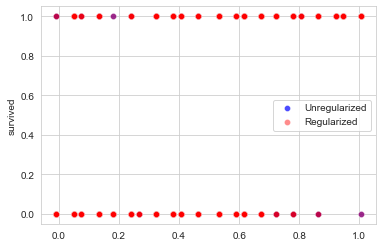

(0.4014685594325059, 0.4014685594312323)

In [849]:
# 3. Use regularized regression to build a purely predictive model. Can you improve your accuracy? Plot the regularized model against the interpretable model predictions in a regression plot to make your case. 

from sklearn.metrics import r2_score

est = sm.OLS(y, sm.add_constant(X_model3)).fit(cov_type='HC2')
#L1_wt=0: ridge fit, L1_wt=1: lasso fit, or method=‘elastic_net’
est_ridge = sm.OLS(y, sm.add_constant(X_model3)).fit_regularized(L1_wt=0) 
est_lasso = sm.OLS(y, sm.add_constant(X_model3)).fit_regularized(L1_wt=1)
# est_elastic = sm.OLS(y, sm.add_constant(X_model3)).fit_regularized(method='elastic_net', alpha = 0.2)
y_hat = est.predict(sm.add_constant(X_model3)) #predict without ridge
y_hat_ridge = est_ridge.predict(sm.add_constant(X_model3)) #Predict X values with ridge
y_hat_lasso = est_lasso.predict(sm.add_constant(X_model3)) #Predict X values with lasso
# y_hat_elastic = est_elastic.predict(sm.add_constant(X_model3)) #Predict X values with elastic net


#Plot the regularized vs unregularized models
sns.set_style('whitegrid')
sns.scatterplot(x=y_hat,y=y,color='blue',alpha=.7,label='Unregularized')

#Can also set x to est.fittedvalues? or est_ridge.fittedvalues...
sns.scatterplot(x=y_hat_ridge,y=y,color='red',alpha=.45,label='Regularized')
plt.show()


r2_score(y,y_hat_ridge), r2_score(y, y_hat_lasso) #, r2_score(y, y_hat_elastic) 

# Ridge is better by a very very very small margin. And is basically no different from my own interpretable model. 

# House Price prediction

Using the techniques you learned, use everything you can to build the best **interpretable** (eg. non-regularized) regression model on the `house_price.csv` dataset. You also have `house_price_data_description.txt` to help -- full description of each column.

Here's a brief version of what you'll find in the data description file.

**SalePrice** - the property's sale price in dollars. **This is the target variable that you're trying to predict.**

Here are the features you can use (or engineer into new features!) for your `X` matrix:

    MSSubClass: The building class
    MSZoning: The general zoning classification
    LotFrontage: Linear feet of street connected to property
    LotArea: Lot size in square feet
    Street: Type of road access
    Alley: Type of alley access
    LotShape: General shape of property
    LandContour: Flatness of the property
    Utilities: Type of utilities available
    LotConfig: Lot configuration
    LandSlope: Slope of property
    Neighborhood: Physical locations within Ames city limits
    Condition1: Proximity to main road or railroad
    Condition2: Proximity to main road or railroad (if a second is present)
    BldgType: Type of dwelling
    HouseStyle: Style of dwelling
    OverallQual: Overall material and finish quality
    OverallCond: Overall condition rating
    YearBuilt: Original construction date
    YearRemodAdd: Remodel date
    RoofStyle: Type of roof
    RoofMatl: Roof material
    Exterior1st: Exterior covering on house
    Exterior2nd: Exterior covering on house (if more than one material)
    MasVnrType: Masonry veneer type
    MasVnrArea: Masonry veneer area in square feet
    ExterQual: Exterior material quality
    ExterCond: Present condition of the material on the exterior
    Foundation: Type of foundation
    BsmtQual: Height of the basement
    BsmtCond: General condition of the basement
    BsmtExposure: Walkout or garden level basement walls
    BsmtFinType1: Quality of basement finished area
    BsmtFinSF1: Type 1 finished square feet
    BsmtFinType2: Quality of second finished area (if present)
    BsmtFinSF2: Type 2 finished square feet
    BsmtUnfSF: Unfinished square feet of basement area
    TotalBsmtSF: Total square feet of basement area
    Heating: Type of heating
    HeatingQC: Heating quality and condition
    CentralAir: Central air conditioning
    Electrical: Electrical system
    1stFlrSF: First Floor square feet
    2ndFlrSF: Second floor square feet
    LowQualFinSF: Low quality finished square feet (all floors)
    GrLivArea: Above grade (ground) living area square feet
    BsmtFullBath: Basement full bathrooms
    BsmtHalfBath: Basement half bathrooms
    FullBath: Full bathrooms above grade
    HalfBath: Half baths above grade
    Bedroom: Number of bedrooms above basement level
    Kitchen: Number of kitchens
    KitchenQual: Kitchen quality
    TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    Functional: Home functionality rating
    Fireplaces: Number of fireplaces
    FireplaceQu: Fireplace quality
    GarageType: Garage location
    GarageYrBlt: Year garage was built
    GarageFinish: Interior finish of the garage
    GarageCars: Size of garage in car capacity
    GarageArea: Size of garage in square feet
    GarageQual: Garage quality
    GarageCond: Garage condition
    PavedDrive: Paved driveway
    WoodDeckSF: Wood deck area in square feet
    OpenPorchSF: Open porch area in square feet
    EnclosedPorch: Enclosed porch area in square feet
    3SsnPorch: Three season porch area in square feet
    ScreenPorch: Screen porch area in square feet
    PoolArea: Pool area in square feet
    PoolQC: Pool quality
    Fence: Fence quality
    MiscFeature: Miscellaneous feature not covered in other categories
    MiscVal: $Value of miscellaneous feature
    MoSold: Month Sold
    YrSold: Year Sold
    SaleType: Type of sale
    SaleCondition: Condition of sale


In [897]:
# To read data description in depth:
txt = open('data/house_price_data_description.txt','r')
print(txt.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [856]:
df_house = pd.read_csv('data/house_price.csv')
df_house.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
251,252,120,RM,44.0,4750,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Family,235000
44,45,20,RL,70.0,7945,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,141000
1134,1135,60,RL,57.0,8773,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,169000
1291,1292,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,119500
490,491,160,RM,NaN,2665,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,115000


In [857]:
# Data cleaning: Let's see where the na's are
total = df_house.isnull().sum().sort_values(ascending=False)
percent_1 = df_house.isnull().sum()/df_house.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(20)

# new_df.isnull().sum()

,Total,%
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageCond,81,5.5
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5


In [858]:
# Data cleaning cont'd:
# Filling in all the appropriate nans with NA (appropriate because the NaN represents 'NO pool' or 'NO garage' etc.)

to_fill_NA = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'MasVnrType']

for var in to_fill_NA:
    df_house[var] = df_house[var].fillna('NA')

# Filling LotFrontage with the mean lotfrontage value
df_house.LotFrontage = df_house.LotFrontage.fillna(df_house.LotFrontage.mean())

# Filling GarageYrBlt with the mean year (even with NO garage, because putting 0 would skew the data)
df_house.GarageYrBlt = df_house.GarageYrBlt.fillna(df_house.GarageYrBlt.mean())
df_house.GarageYrBlt = df_house.GarageYrBlt.astype('int64')

# Filling MasVnrArea with 0 because probably none. 
df_house.MasVnrArea = df_house.MasVnrArea.fillna(0)

# Dropping the last na (from Electrical)
df_house = df_house.dropna()

# Checking that no more data is missing
df_house.isnull().sum().sort_values(ascending=False)

SalePrice       0
Heating         0
RoofStyle       0
RoofMatl        0
Exterior1st     0
               ..
TotRmsAbvGrd    0
Functional      0
Fireplaces      0
FireplaceQu     0
Id              0
Length: 81, dtype: int64

In [935]:
# separating into categorical and continous features

#categorical:
cat_var_house = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope",
          "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "OverallQual", "OverallCond", "RoofStyle",
          "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", 
          "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical",
          "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", 
           "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

#continous:
con_var_house = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF",
       "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
       "PoolArea", "MiscVal"]

#to drop 
to_drop = ['SalePrice', 'Id', 'SalePrice_log']

In [958]:
# dropping cols, OHE cols, and squaring/cubing cols:
X = df_house.copy()

mycolumns = X.columns

for col in mycolumns:
    
    if col in to_drop:
        X = X.drop(columns = [col])
        
    elif col in cat_var_house:
        name = col + "_"
        X = X.join(pd.get_dummies(X[col], drop_first = True, prefix = name))
        X = X.drop(columns = [col])
    
    elif col in con_var_house:
        X[col] = X[col].astype(int)
        name = col + "^2"
        X[name] = X[col] ** 2
        name = col + "^3"
        X[name] = X[col] ** 3 

(X.columns)

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleType__ConLI', 'SaleType__ConLw', 'SaleType__New', 'SaleType__Oth',
       'SaleType__WD', 'SaleCondition__AdjLand', 'SaleCondition__Alloca',
       'SaleCondition__Family', 'SaleCondition__Normal',
       'SaleCondition__Partial'],
      dtype='object', length=326)

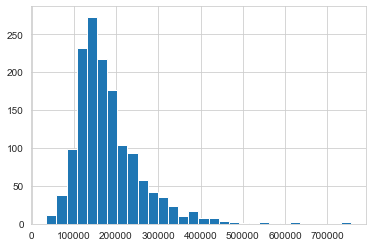

In [919]:
df_house.SalePrice.hist(bins=30)

In [937]:
# defining y
# Using log to get a more 'normal distribution'
df_house['SalePrice_log'] = df_house.SalePrice.apply(np.log)
y = df_house['SalePrice_log']


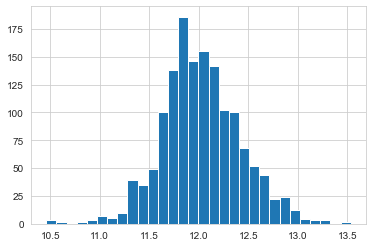

In [921]:
df_house.SalePrice_log.hist(bins=30) #looks beautiful, *chefs kiss* 

In [938]:
# model
est_house = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')
est_house.summary()


/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 326, but rank is 74
  warnings.warn('covariance of constraints does not have full '


0.000       0.004       0.013
HouseStyle__1.5Unf         0.0016      0.001      2.352      0.019       0.000       0.003
HouseStyle__1Story         0.0024      0.004      0.533      0.594      -0.006       0.011
HouseStyle__2.5Fin         0.0012      0.000      3.488      0.000       0.001       0.002
HouseStyle__2.5Unf     -9.704e-05      0.000     -0.238      0.812      -0.001       0.001
HouseStyle__2Story        -0.0032      0.005     -0.694      0.488      -0.012       0.006
HouseStyle__SFoyer        -0.0008      0.001     -0.624      0.532      -0.003       0.002
HouseStyle__SLvl          -0.0014      0.004     -0.397      0.692      -0.008       0.006
OverallQual__2            -0.0011      0.000     -4.929      0.000      -0.002      -0.001
OverallQual__3            -0.0025      0.001     -3.226      0.001      -0.004      -0.001
OverallQual__4            -0.0268      0.006     -4.269      0.000      -0.039      -0.015
OverallQual__5            -0.0012      0.008     -0.156      0.876      -0.016       0.014
OverallQual__6             0.0196      0.007      2.904      0.004       0.006       0.033
OverallQual__7             0.0125      0.007      1.871      0.061      -0.001       0.025
OverallQual__8            -0.0106      0.005     -2.056      0.040      -0.021      -0.000
OverallQual__9             0.0094      0.001      7.728      0.000       0.007       0.012
OverallQual__10            0.0012      0.000      2.816      0.005       0.000       0.002
OverallCond__2            -0.0016      0.000     -3.998      0.000      -0.002      -0.001
OverallCond__3            -0.0047      0.001     -3.645      0.000      -0.007      -0.002
OverallCond__4            -0.0154      0.002     -7.039      0.000      -0.020      -0.011
OverallCond__5            -0.0385      0.007     -5.904      0.000      -0.051      -0.026
OverallCond__6             0.0105      0.007      1.486      0.137      -0.003       0.024
OverallCond__7             0.0599      0.008      7.691      0.000       0.045       0.075
OverallCond__8            -0.0093      0.002     -5.081      0.000      -0.013      -0.006
OverallCond__9            -0.0007      0.001     -0.838      0.402      -0.002       0.001
RoofStyle__Gable          -0.0141      0.006     -2.515      0.012      -0.025      -0.003
RoofStyle__Gambrel         0.0010      0.000      2.679      0.007       0.000       0.002
RoofStyle__Hip             0.0127      0.005      2.431      0.015       0.002       0.023
RoofStyle__Mansard         0.0010      0.000      2.201      0.028       0.000       0.002
RoofStyle__Shed            0.0007      0.000      4.709      0.000       0.000       0.001
RoofMatl__CompShg          0.0013      0.001      1.191      0.234      -0.001       0.003
RoofMatl__Membran          0.0002      0.000      2.015      0.044    5.73e-06       0.000
RoofMatl__Metal            0.0002      0.000      1.198      0.231      -0.000       0.000
RoofMatl__Roll            -0.0002      0.000     -1.799      0.072      -0.000    1.87e-05
RoofMatl__Tar&Grv         -0.0020      0.001     -2.415      0.016      -0.004      -0.000
RoofMatl__WdShake          0.0007      0.000      2.249      0.025    8.92e-05       0.001
RoofMatl__WdShngl      -9.676e-05      0.000     -0.373      0.709      -0.001       0.000
Exterior1st__AsphShn    3.077e-05   8.04e-05      0.383      0.702      -0.000       0.000
Exterior1st__BrkComm      -0.0011      0.000     -4.108      0.000      -0.002      -0.001
Exterior1st__BrkFace       0.0029      0.001      2.709      0.007       0.001       0.005
Exterior1st__CBlock        0.0002      0.000      1.672      0.095   -3.75e-05       0.000
Exterior1st__CemntBd      -0.0048      0.004     -1.292      0.196      -0.012       0.003
Exterior1st__HdBoard   -8.324e-05      0.004     -0.019      0.985      -0.009       0.009
Exterior1st__ImStucc     5.19e-05      7e-05      0.741      0.459   -8.54e-05       0.000
Exterior1st__MetalSd       0.0136      0.004      3.292  

In [923]:
# To see all features in model:
est_house.params.index

Index(['const', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType__ConLI', 'SaleType__ConLw', 'SaleType__New', 'SaleType__Oth',
       'SaleType__WD', 'SaleCondition__AdjLand', 'SaleCondition__Alloca',
       'SaleCondition__Family', 'SaleCondition__Normal',
       'SaleCondition__Partial'],
      dtype='object', length=328)

In [ ]:
# for p in pvals:
#     kept_cols = est_house.loc(pvalues >= .05)

In [853]:
# est_house.pvalues.sort_values(ascending=True).index.

In [939]:
# Want to grab pvalues of the features so I can select the ones above 0.05
pvals = pd.DataFrame(est_house.pvalues)
# pvals['pvalue'] = pvals.columns
pvals.columns = ['pvalue']
# X_dropped = X.drop(pvals[pvals['pvalue'] >= 0.4].index)
bye = list(pvals[pvals['pvalue'] >= 0.4].index[1:])
bye2 = list(pvals[pvals['pvalue'] > 0.05].index[1:])
X_dropped = X.drop(columns=bye)
X_dropped_2 = X.drop(columns=bye2)

In [940]:
est_house_1=sm.OLS(y, sm.add_constant(X_dropped)).fit(cov_type='HC2')
est_house_1.summary()

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 230, but rank is 49
  warnings.warn('covariance of constraints does not have full '


0.241      -0.000       0.001
MSSubClass__30             0.0039      0.002      2.339      0.019       0.001       0.007
MSSubClass__40             0.0005      0.000      2.430      0.015    9.12e-05       0.001
MSSubClass__45             0.0012      0.000      2.402      0.016       0.000       0.002
MSSubClass__60             0.0049      0.002      2.827      0.005       0.002       0.008
MSSubClass__70             0.0023      0.001      1.642      0.101      -0.000       0.005
MSSubClass__75          5.447e-05      0.000      0.163      0.870      -0.001       0.001
MSSubClass__90            -0.0230      0.002    -10.635      0.000      -0.027      -0.019
MSSubClass__120            0.0034      0.003      1.241      0.215      -0.002       0.009
MSSubClass__180           -0.0004      0.001     -0.702      0.483      -0.002       0.001
MSSubClass__190           -0.0040      0.001     -3.667      0.000      -0.006      -0.002
MSZoning__RH              -0.0028      0.001     -3.329      0.001      -0.004      -0.001
MSZoning__RL               0.0347      0.007      5.193      0.000       0.022       0.048
MSZoning__RM              -0.0275      0.006     -4.817      0.000      -0.039      -0.016
LotFrontage^2          -2.727e-05   1.14e-05     -2.387      0.017   -4.97e-05   -4.88e-06
LotFrontage^3           5.458e-08   3.03e-08      1.799      0.072   -4.87e-09    1.14e-07
LotArea^2              -6.127e-11        nan        nan        nan         nan         nan
LotArea^3                2.29e-16        nan        nan        nan         nan         nan
Street__Pave               0.0006      0.000      1.596      0.110      -0.000       0.001
Alley__NA                  0.0078      0.002      3.937      0.000       0.004       0.012
Alley__Pave               -0.0025      0.001     -2.115      0.034      -0.005      -0.000
LotShape__IR3             -0.0020      0.000     -5.973      0.000      -0.003      -0.001
LandContour__HLS           0.0055      0.004      1.483      0.138      -0.002       0.013
LandContour__Lvl          -0.0059      0.009     -0.681      0.496      -0.023       0.011
LotConfig__CulDSac     -4.076e-05      0.001     -0.041      0.967      -0.002       0.002
LotConfig__FR2            -0.0002      0.001     -0.192      0.848      -0.003       0.002
LotConfig__FR3         -7.596e-05      0.000     -0.370      0.711      -0.000       0.000
LandSlope__Sev          4.868e-05      0.001      0.083      0.934      -0.001       0.001
Neighborhood__BrkSide      0.0070      0.002      4.445      0.000       0.004       0.010
Neighborhood__Crawfor      0.0108      0.002      5.488      0.000       0.007       0.015
Neighborhood__Edwards      0.0102      0.003      3.546      0.000       0.005       0.016
Neighborhood__Gilbert      0.0038      0.002      2.202      0.028       0.000       0.007
Neighborhood__IDOTRR      -0.0031      0.001     -2.058      0.040      -0.006      -0.000
Neighborhood__MeadowV     -0.0016      0.001     -1.403      0.161      -0.004       0.001
Neighborhood__NAmes       -0.0117      0.007     -1.641      0.101      -0.026       0.002
Neighborhood__NWAmes      -0.0023      0.002     -1.165      0.244      -0.006       0.002
Neighborhood__NoRidge     -0.0026      0.001     -1.887      0.059      -0.005       0.000
Neighborhood__NridgHt      0.0143      0.002      7.918      0.000       0.011       0.018
Neighborhood__OldTown     -0.0191      0.003     -6.852      0.000      -0.025      -0.014
Neighborhood__SWISU        0.0051      0.001      4.982      0.000       0.003       0.007
Neighborhood__Sawyer      -0.0032      0.003     -1.135      0.256      -0.009       0.002
Neighborhood__SawyerW     -0.0062      0.002     -3.539      0.000      -0.010      -0.003
Neighborhood__Timber       0.0005      0.001      0.543      0.587      -0.001       0.002
Neighborhood__Veenker   8.505e-07      0.000      0.002      0.999      -0.001       0.001
Condition1__Feedr         -0.0213      0.005     -4.459  

In [941]:
est_house_2=sm.OLS(y, sm.add_constant(X_dropped_2)).fit(cov_type='HC2')
est_house_2.summary()

# Tried removing all features with p > 0.05 but more popped up... need to make a function to try that for me. 

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 151, but rank is 140
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     1027.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:06:18   Log-Likelihood:                 835.90
No. Observations:                1459   AIC:                            -1380.
Df Residuals:                    1313   BIC:                            -608.1
Df Model:                         145                                         
Covariance Type:                  HC2                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      6.2016      0.961      6.452      0.000       4.318       8.085
LotFrontage                0.0010      0.002      0.503      0.615      -0.003       0.005
LotArea                 9.288e-06    1.7e-06      5.472      0.000    5.96e-06    1.26e-05
YearBuilt                  0.0009      0.000      1.989      0.047    1.34e-05       0.002
YearRemodAdd               0.0016      0.000      5.121      0.000       0.001       0.002
FullBath                   0.0912      0.013      7.264      0.000       0.067       0.116
BedroomAbvGr               0.0329      0.008      3.931      0.000       0.017       0.049
KitchenAbvGr              -0.0363      0.041     -0.892      0.372      -0.116       0.043
Fireplaces                 0.0634      0.018      3.480      0.001       0.028       0.099
GarageCars                 0.0340      0.013      2.620      0.009       0.009       0.059
MSSubClass__30            -0.1299      0.031     -4.170      0.000      -0.191      -0.069
MSSubClass__40            -0.0723      0.171     -0.423      0.672      -0.407       0.263
MSSubClass__45            -0.1767      0.228     -0.774      0.439      -0.624       0.271
MSSubClass__60             0.0471      0.013      3.513      0.000       0.021       0.073
MSSubClass__70             0.0631      0.029      2.172      0.030       0.006       0.120
MSSubClass__75             0.0713      0.053      1.338      0.181      -0.033       0.176
MSSubClass__90             0.0183      0.021      0.862      0.388      -0.023       0.060
MSSubClass__120            0.0282      0.024      1.194      0.233      -0.018       0.074
MSSubClass__190           -0.0127      0.110     -0.115      0.908      -0.229       0.203
MSZoning__RL               0.0158      0.020      0.787      0.431      -0.024       0.055
MSZoning__RM               0.0170      0.032      0.536      0.592      -0.045       0.079
LotFrontage^2           5.501e-06   2.12e-05      0.260      0.795    -3.6e-05     4.7e-05
LotFrontage^3          -4.473e-08   6.92e-08     -0.646      0.518    -1.8e-07    9.09e-08
LotArea^2              -3.468e-11   1.18e-11     -2.935      0.003   -5.78e-11   -1.15e-11
Street__Pave               0.2308      0.104      2.216      0.027       0.027       0.435
LotShape__IR3             -0.0779      0.093     -0.840      0.401      -0.260       0.104
LandContour__HLS          -0.0123      0.028     -0.439      0.661      -0.067       0.043
Neighborhood__Crawfor      0.1401      0.031      4.448      0.000       0.078       0.202
Neighborhood__Edwards     -0.0535      0.023     -2.350      0.019      -0.098      -0.009
Neighborhood__IDOTRR      -0.1066      0.051     -2.074      0.038      -0.207      -0.006
Neighborhood__MeadowV     -0.1719      0.031     -5.505      0.000      -0.233  

In [942]:
len(list(pvals_2[pvals_2['pvalue'] > 0.05].index[1:]))

41

In [943]:
pvals_2= pd.DataFrame(est_house_2.pvalues)
# pvals['pvalue'] = pvals.columns
pvals_2.columns = ['pvalue']
# X_dropped = X.drop(pvals[pvals['pvalue'] >= 0.4].index)
# bye = list(pvals[pvals['pvalue'] >= 0.4].index[1:])
bye3 = list(pvals_2[pvals_2['pvalue'] > 0.05].index[1:])
# X_dropped = X.drop(columns=bye)
X_dropped_3 = X.drop(columns=bye3)

In [944]:
est_house_3=sm.OLS(y, sm.add_constant(X_dropped_3)).fit(cov_type='HC2')
est_house_3.summary()

/Users/mayarossi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 221, but rank is 67
  warnings.warn('covariance of constraints does not have full '


0.013    3.65e-05       0.000
1stFlrSF                   0.0002      0.000      0.747      0.455      -0.000       0.001
2ndFlrSF               -8.716e-06      0.000     -0.037      0.971      -0.000       0.000
LowQualFinSF               0.0003      0.001      0.462      0.644      -0.001       0.002
GrLivArea                  0.0005      0.000      1.727      0.084   -6.78e-05       0.001
BsmtFullBath              -0.0031      0.011     -0.280      0.779      -0.024       0.018
BsmtHalfBath               0.0025      0.004      0.646      0.518      -0.005       0.010
FullBath                  -0.0078      0.008     -0.988      0.323      -0.023       0.008
HalfBath                  -0.0098      0.008     -1.250      0.211      -0.025       0.006
BedroomAbvGr              -0.0217      0.009     -2.506      0.012      -0.039      -0.005
TotRmsAbvGrd               0.0118      0.006      2.021      0.043       0.000       0.023
Fireplaces                 0.0678      0.008      8.942      0.000       0.053       0.083
GarageYrBlt                0.0004      0.001      0.660      0.509      -0.001       0.001
GarageCars                 0.0006      0.007      0.085      0.932      -0.013       0.014
GarageArea                 0.0004      0.000      2.376      0.018    6.46e-05       0.001
WoodDeckSF                 0.0002      0.000      1.417      0.156   -7.65e-05       0.000
OpenPorchSF                0.0003      0.000      0.839      0.402      -0.000       0.001
EnclosedPorch              0.0007      0.001      1.360      0.174      -0.000       0.002
3SsnPorch                  0.0006      0.001      0.563      0.574      -0.001       0.003
ScreenPorch                0.0011      0.001      1.274      0.203      -0.001       0.003
PoolArea                  -0.0140      0.018     -0.797      0.425      -0.049       0.020
MiscVal                -5.448e-05    2.4e-05     -2.268      0.023      -0.000   -7.41e-06
MoSold                  9.973e-05      0.002      0.062      0.950      -0.003       0.003
YrSold                  9.376e-05      0.000      0.194      0.846      -0.001       0.001
MSSubClass__30            -0.0025      0.002     -1.101      0.271      -0.007       0.002
MSSubClass__50            -0.0023      0.006     -0.373      0.709      -0.015       0.010
MSSubClass__60            -0.0045      0.005     -0.988      0.323      -0.013       0.004
MSSubClass__70             0.0061      0.002      3.201      0.001       0.002       0.010
MSSubClass__80             0.0037      0.004      1.029      0.304      -0.003       0.011
MSSubClass__85             0.0014      0.001      1.676      0.094      -0.000       0.003
MSSubClass__160            0.0028      0.002      1.261      0.207      -0.002       0.007
MSSubClass__180            0.0007      0.001      1.041      0.298      -0.001       0.002
MSZoning__FV               0.0107      0.003      3.590      0.000       0.005       0.017
MSZoning__RH              -0.0015      0.000     -3.215      0.001      -0.002      -0.001
LotArea^2              -1.116e-10   2.61e-11     -4.266      0.000   -1.63e-10   -6.03e-11
LotArea^3               3.794e-16   9.53e-17      3.982      0.000    1.93e-16    5.66e-16
Street__Pave               0.0003      0.000      0.953      0.341      -0.000       0.001
Alley__NA                 -0.0060      0.002     -2.650      0.008      -0.010      -0.002
Alley__Pave                0.0048      0.002      2.592      0.010       0.001       0.008
LotShape__IR2             -0.0004      0.001     -0.364      0.716      -0.003       0.002
LotShape__Reg             -0.0112      0.008     -1.373      0.170      -0.027       0.005
LandContour__Low          -0.0020      0.003     -0.734      0.463      -0.007       0.003
LandContour__Lvl          -0.0041      0.010     -0.402      0.688      -0.024       0.016
Utilities__NoSeWa          0.0003      0.000      2.637      0.008    8.13e-05       0.001
LotConfig__CulDSac         0.0020      0.002      0.883  

In [981]:
#Still working on this.. 
# There must be a for loop or a recursive function that can keep getting rid of the features that have pvalue > .05

# Ideally want this function to gather all the AIC's as it runs through recursion and then returns the list of features with the lowest AIC. 
my_aic = []

def myrecur(mymodel, my_X, mypval=0.05):
    """Ideally want this function to gather all the 
    AIC's as it runs through recursion and then returns 
    the list of features with the lowest AIC. 
    """
    pvals_2= pd.DataFrame(mymodel.pvalues)
    pvals_2.columns = ['pvalue']
    coefs = pd.DataFrame(mymodel.params)
    coefs.columns = ['coefs_col']
    if len(list(pvals_2[pvals_2['pvalue'] > mypval].index[1:])) <= 0: # [1:] because will give error if tries to remove const. 
        bye4 = list(coefs[coefs['coefs_col'] < 0.01].index[1:])
        X_final = my_X.drop(columns=bye4)
        return f'features kept:{list(X_final)}, R2 = {mymodel.rsquared}, AIC = {mymodel.aic}' #lowest AIC model? so need all remaining columns (too hard to get all columns that were dropped), and their coeffs, and R2 (essentially the summary)
    else:
        bye3 = list(pvals_2[pvals_2['pvalue'] > mypval].index[1:])
        X_dropped_3 = my_X.drop(columns=bye3)
        mymodel = sm.OLS(y, sm.add_constant(X_dropped_3)).fit(cov_type='HC2')
        # my_aic.append(mymodel.aic)
    return myrecur(mymodel, X_dropped_3)
        # print(len(bye3))
        # print(mymodel.aic)
        # print(list(X_dropped_3))
        # print('~~~~~')
    
    # need a refresher on recursion, cant remember how to get it to run again. Need 'mymodel' in here somewhere, but where it equals smt slighly less (in this case, less columns)

est_house = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC2')

myrecur(est_house, X, 0.04)


"features kept:['LotFrontage', 'FullBath', 'BedroomAbvGr', 'Fireplaces', 'Neighborhood__Crawfor', 'OverallQual__8', 'OverallQual__9', 'OverallQual__10', 'Exterior1st__BrkFace', 'Exterior1st__Stone', 'Exterior2nd__Other', 'BsmtFinType1__GLQ', 'CentralAir__Y', 'GarageFinish__RFn'], R2 = 0.8381833163602572, AIC = -1122.5390293560963"

In [892]:
len(list(pvals_2[pvals_2['pvalue'] > 0.0, {mymodel.R2}

49

In [983]:
tryme = X[['LotFrontage', 'FullBath', 'BedroomAbvGr', 'Fireplaces', 'Neighborhood__Crawfor', 'OverallQual__8', 'OverallQual__9', 'OverallQual__10', 'Exterior1st__BrkFace', 'Exterior1st__Stone', 'Exterior2nd__Other', 'BsmtFinType1__GLQ', 'CentralAir__Y', 'GarageFinish__RFn']]

omg = sm.OLS(y, sm.add_constant(tryme)).fit(cov_type='HC2')
omg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SalePrice_log   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     1315.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        00:58:15   Log-Likelihood:                 211.28
No. Observations:                1459   AIC:                            -392.6
Df Residuals:                    1444   BIC:                            -313.3
Df Model:                          14                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.9573      0.051    216.030      0.000      10.858      11.057
LotFrontage               0.0016      0.001      2.676      0.007       0.000       0.003
FullBath                  0.2106      0.013     16.082      0.000       0.185       0.236
BedroomAbvGr              0.0406      0.009      4.345      0.000       0.022       0.059
Fireplaces                0.1281      0.010     12.867      0.000       0.109       0.148
Neighborhood__Crawfor     0.1719      0.030      5.713      0.000       0.113       0.231
OverallQual__8            0.3055      0.019     16.389      0.000       0.269       0.342
OverallQual__9            0.5711      0.038     15.099      0.000       0.497       0.645
OverallQual__10           0.5344      0.094      5.697      0.000       0.351       0.718
Exterior1st__BrkFace      0.0541      0.034      1.593      0.111      -0.012       0.121
Exterior1st__Stone        0.2952      0.051      5.816      0.000       0.196       0.395
Exterior2nd__Other        0.1495      0.019      8.016      0.000       0.113       0.186
BsmtFinType1__GLQ         0.1665      0.013     13.322      0.000       0.142       0.191
CentralAir__Y             0.3154      0.034      9.333      0.000       0.249       0.382
GarageFinish__RFn         0.0812      0.012      6.786      0.000       0.058       0.105
==============================================================================
Omnibus:                      162.684   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              614.940
Skew:                          -0.495   Prob(JB):                    2.93e-134
Kurtosis:                       6.023   Cond. No.                     2.82e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The condition number is large, 2.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [720]:
# Tried a cute little RFE to see which features it would suggest keeping. 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

num_feats=18
X_norm = MinMaxScaler().fit_transform(X)
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
list(rfe_feature)

Fitting estimator with 326 features.
Fitting estimator with 316 features.
Fitting estimator with 306 features.
Fitting estimator with 296 features.
Fitting estimator with 286 features.
Fitting estimator with 276 features.
Fitting estimator with 266 features.
Fitting estimator with 256 features.
Fitting estimator with 246 features.
Fitting estimator with 236 features.
Fitting estimator with 226 features.
Fitting estimator with 216 features.
Fitting estimator with 206 features.
Fitting estimator with 196 features.
Fitting estimator with 186 features.
Fitting estimator with 176 features.
Fitting estimator with 166 features.
Fitting estimator with 156 features.
Fitting estimator with 146 features.
Fitting estimator with 136 features.
Fitting estimator with 126 features.
Fitting estimator with 116 features.
Fitting estimator with 106 features.
Fitting estimator with 96 features.
Fitting estimator with 86 features.
Fitting estimator with 76 features.
Fitting estimator with 66 features.
Fitti

['MSZoning__RL',
 'OverallQual__3',
 'OverallQual__4',
 'OverallQual__5',
 'OverallQual__6',
 'OverallQual__7',
 'OverallQual__8',
 'OverallQual__9',
 'OverallQual__10',
 'RoofMatl__CompShg',
 'RoofMatl__Membran',
 'RoofMatl__Metal',
 'RoofMatl__Roll',
 'RoofMatl__Tar&Grv',
 'RoofMatl__WdShake',
 'RoofMatl__WdShngl',
 'Exterior1st__BrkComm',
 'Heating__GasW']

In [730]:
RFE_X = X[['Neighborhood__Crawfor',
 'Neighborhood__Edwards',
 'Neighborhood__IDOTRR',
 'Neighborhood__MeadowV',
 'Neighborhood__StoneBr',
 'Condition1__RRAe',
 'OverallQual__3',
 'OverallQual__9',
 'OverallQual__10',
 'OverallCond__3',
 'OverallCond__4',
 'OverallCond__8',
 'OverallCond__9',
 'RoofStyle__Mansard',
 'Exterior1st__BrkFace',
 'ExterQual__Fa',
 'CentralAir__Y',
 'Functional__Typ']]

omg = sm.OLS(y, RFE_X).fit(cov_type='HC2')
omg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          SalePrice_log   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.453e+04
Date:                Tue, 19 Jan 2021   Prob (F-statistic):                        0.00
Time:                        16:35:49   Log-Likelihood:                         -3082.2
No. Observations:                1459   AIC:                                      6200.
Df Residuals:                    1441   BIC:                                      6296.
Df Model:                          18                                                  
Covariance Type:                  HC2                                                  
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Neighborhood__Crawfor     1.0309      0.332      3.105      0.002       0.380       1.682
Neighborhood__Edwards     1.0084      0.309      3.264      0.001       0.403       1.614
Neighborhood__IDOTRR      1.2569      0.544      2.311      0.021       0.191       2.323
Neighborhood__MeadowV    -0.8868      0.350     -2.536      0.011      -1.572      -0.201
Neighborhood__StoneBr     0.7897      0.323      2.447      0.014       0.157       1.422
Condition1__RRAe          1.1343      0.771      1.471      0.141      -0.377       2.645
OverallQual__3            2.0890      0.829      2.520      0.012       0.464       3.714
OverallQual__9            0.6125      0.067      9.181      0.000       0.482       0.743
OverallQual__10           0.7235      0.174      4.165      0.000       0.383       1.064
OverallCond__3            2.7827      0.816      3.408      0.001       1.182       4.383
OverallCond__4            2.3499      0.526      4.464      0.000       1.318       3.382
OverallCond__8            0.4604      0.281      1.640      0.101      -0.090       1.011
OverallCond__9           -0.2125      0.123     -1.730      0.084      -0.453       0.028
RoofStyle__Mansard        1.7156      1.184      1.449      0.147      -0.606       4.037
Exterior1st__BrkFace      0.6779      0.318      2.132      0.033       0.055       1.301
ExterQual__Fa             3.2271      1.360      2.373      0.018       0.561       5.893
CentralAir__Y             6.8013      0.386     17.603      0.000       6.044       7.559
Functional__Typ           5.2641      0.391     13.464      0.000       4.498       6.030
==============================================================================
Omnibus:                      606.844   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3043.933
Skew:                           1.916   Prob(JB):                         0.00
Kurtosis:                       8.949   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [729]:
#Also this way, had LinearRegression(penalty='l1') but that was for logistic regression, dont know what the equivalent is for linear regression. But decent features. 
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

embeded_lr_selector = SelectFromModel(LinearRegression(), max_features=num_feats)
X = sm.add_constant(X)
embeded_lr_selector.fit(X, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')
list(embeded_lr_feature)


18 selected features


['Neighborhood__Crawfor',
 'Neighborhood__Edwards',
 'Neighborhood__IDOTRR',
 'Neighborhood__MeadowV',
 'Neighborhood__StoneBr',
 'Condition1__RRAe',
 'OverallQual__3',
 'OverallQual__9',
 'OverallQual__10',
 'OverallCond__3',
 'OverallCond__4',
 'OverallCond__8',
 'OverallCond__9',
 'RoofStyle__Mansard',
 'Exterior1st__BrkFace',
 'ExterQual__Fa',
 'CentralAir__Y',
 'Functional__Typ']